In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib
import seaborn as sns

sys.path.append(str(Path(os.getcwd()).parent))

In [4]:
from src import extract_tree_stats, curve_inference, estimators, loader, tests

# Test gamma statistic analytically

In [42]:
S = int(1e5)
n = 101

r = scipy.special.binom(np.arange(2, n+1), 2)
coal_times = scipy.stats.expon(scale=1/r).rvs(size=(S, n-1))

In [51]:
coal_times[:,50].mean()

0.0007569039743873697

In [31]:
gamma_stats = [tests.gam(C) for C in coal_times]

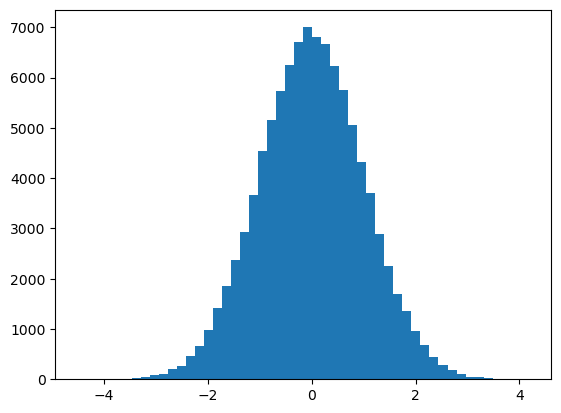

In [32]:
plt.hist(gamma_stats, bins=50);

# Test on one file

In [95]:
logNs = "-3.0"

filenames = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs={logNs}/logNUd=2/seed=*/output.trees.tsz"
)

In [99]:
%%time
ts = loader.load_tree_sequence_from_slim(
    filename = filenames[0],
    n_samples_per_time = [100],
    sample_times = [0],
    neutral_mutation_rate_per_genome = 0,
    random_seed = 42,
)

CPU times: user 7.11 s, sys: 1.46 s, total: 8.57 s
Wall time: 8 s


In [100]:
_, tree_coal_times, _, _ = extract_tree_stats.extract_tree_sequence(
    ts,
    sample_times = [0],
    sample_sizes = [100],
    Ne=10000, 
    add_neutral=False,
)

In [108]:
tests.gam(tree_coal_times[::-1])

0.30523757518187405

In [145]:
print("Colless:", ts.first().colless_index())
print("Sackin:", ts.first().sackin_index())
print("B1 index:", ts.first().b1_index())
print("B2 index:", ts.first().b2_index())

Colless: 342
Sackin: 824
B1 index: 52.30955988455991
B2 index: 1.5631364691838892


# Test on multiple files

In [150]:
def runme(filename, logNs):
    ts = loader.load_tree_sequence_from_slim(
        filename = filename,
        n_samples_per_time = [100],
        sample_times = [0],
        neutral_mutation_rate_per_genome = 0,
        random_seed = 42,
    )

    _, tree_coal_times, _, _ = extract_tree_stats.extract_tree_sequence(
        ts,
        sample_times = [0],
        sample_sizes = [100],
        Ne=10000, 
        add_neutral=False,
    )

    stat_gamma = tests.gam(tree_coal_times[::-1])
    stat_beta = tests.gam(tree_coal_times[::-1], k=10)

    try:
        colless = ts.first().colless_index()
    except:
        colless = None

    try:
        sackin = ts.first().sackin_index()
    except:
        sackin = None

    try:
        b1 = ts.first().b1_index()
    except:
        b1 = None

    try:
        b2 = ts.first().b2_index()
    except:
        b2 = None
    
    row = [
        logNs, 
        stat_gamma, 
        stat_beta,
        colless,
        sackin,
        b1, 
        b2,
    ]

    return row

rows = joblib.Parallel(n_jobs=40, verbose=10)(
    joblib.delayed(runme)(filename, logNs) \
        for logNs in np.arange(-3, 3.5, 0.5) \
        for filename in glob.glob(
            f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs={logNs}/logNUd=2/seed=*/output.trees.tsz"
        )
)

[Parallel(n_jobs=40)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=40)]: Done   5 tasks      | elapsed:   10.7s
[Parallel(n_jobs=40)]: Done  18 tasks      | elapsed:   18.3s
[Parallel(n_jobs=40)]: Done  33 tasks      | elapsed:   20.0s
[Parallel(n_jobs=40)]: Done  48 tasks      | elapsed:   20.9s
[Parallel(n_jobs=40)]: Done  65 out of 130 | elapsed:   28.5s remaining:   28.5s
[Parallel(n_jobs=40)]: Done  79 out of 130 | elapsed:   32.9s remaining:   21.2s
[Parallel(n_jobs=40)]: Done  93 out of 130 | elapsed:   35.5s remaining:   14.1s
[Parallel(n_jobs=40)]: Done 107 out of 130 | elapsed:   36.7s remaining:    7.9s
[Parallel(n_jobs=40)]: Done 121 out of 130 | elapsed:   39.9s remaining:    3.0s
[Parallel(n_jobs=40)]: Done 130 out of 130 | elapsed:   42.3s finished


In [151]:
res_df = pd.DataFrame(rows, columns=["logNs", "gamma", "beta", "colless", "sackin", "b1_index", "b2_index"])

In [152]:
res_means = res_df.groupby(by="logNs").mean().reset_index()

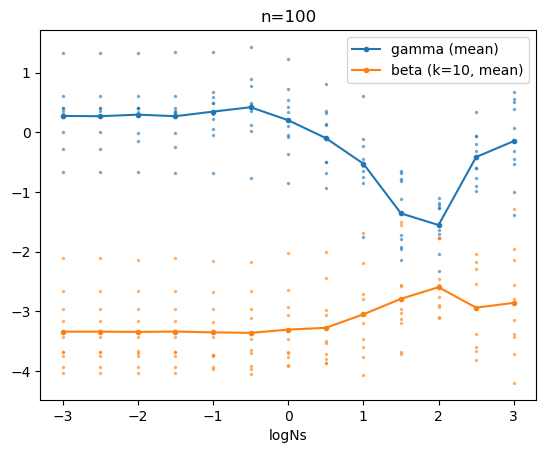

In [153]:
plt.plot(res_means["logNs"], res_means["gamma"], '.-', label="gamma (mean)", color="C0");
plt.plot(res_df["logNs"], res_df["gamma"], '.', color="C0", ms=3, alpha=0.5);

plt.plot(res_means["logNs"], res_means["beta"], '.-', label="beta (k=10, mean)", color="C1");
plt.plot(res_df["logNs"], res_df["beta"], '.', color="C1", ms=3, alpha=0.5);

plt.xlabel("logNs");
plt.title("n=100");
plt.legend();

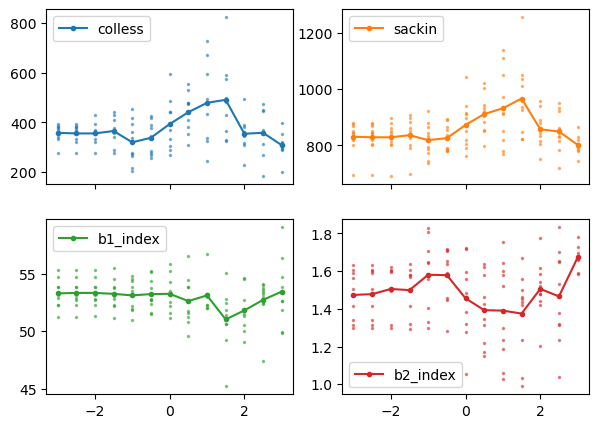

In [157]:
fig, axs = plt.subplots(2, 2, figsize=(7, 5), sharex=True)

for i, (ax, col) in enumerate(zip(axs.ravel(), ["colless", "sackin", "b1_index", "b2_index"])):
    color = "C" + str(i)
    ax.plot(res_means["logNs"], res_means[col], '.-', label=col, color=color);
    ax.plot(res_df["logNs"], res_df[col], '.', color=color, ms=3, alpha=0.5);
    ax.legend()